In [1]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset path
dataset_path = '/content/drive/My Drive/Machine learning/Plant disease/PlantVillage/'
# Define labels or classes based on your dataset structure

# List folders in PlantVillage
folders = os.listdir(dataset_path)
print("Folders:", folders)

# Define a function to load data and labels from specific folders
def load_data(folder_names):
    X, y = [], []
    for folder in folder_names:
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            for img_file in os.listdir(folder_path):
                # Placeholder code to load images
                # For demonstration, using dummy feature extraction, replace with actual image processing
                image_features = np.random.rand(100)  # Example feature vector
                X.append(image_features)
                y.append(0 if 'healthy' in folder else 1)  # Binary label, 0 for healthy, 1 for diseased
    return np.array(X), np.array(y)

# Load sample data (replace 'Pepper__bell___Bacterial_spot' and 'Pepper__bell___healthy' with your target folders)
X, y = load_data(['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define models
models = [
    ('Naive Bayes', GaussianNB()),
    ('Logistic Regression', LogisticRegression(max_iter=1000))
]

# Fit models and calculate likelihoods (using accuracy on train data as proxy for likelihood)
model_accuracies = {}
for model_name, model in models:
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    accuracy = accuracy_score(y_train, y_train_pred)
    model_accuracies[model_name] = accuracy
    print(f"{model_name} Train Accuracy: {accuracy}")

# Define priors for models
priors = [0.5, 0.5]  # Assuming equal priors for simplicity

# Calculate posteriors using priors and likelihoods (model accuracies)
likelihoods = np.array(list(model_accuracies.values()))
priors = np.array(priors)
posteriors = (priors * likelihoods) / np.sum(priors * likelihoods)

print("Model Posterior Probabilities:", posteriors)

# Use posterior-weighted predictions for BMA
def bayesian_model_average(X, models, posteriors):
    predictions = np.zeros((X.shape[0], len(models)))
    for idx, (model_name, model) in enumerate(models):
        predictions[:, idx] = model.predict_proba(X)[:, 1] * posteriors[idx]  # Probability for class '1'
    return np.sum(predictions, axis=1)

# Make BMA predictions
y_pred_bma_prob = bayesian_model_average(X_test, models, posteriors)
y_pred_bma = (y_pred_bma_prob > 0.5).astype(int)

# Evaluate BMA accuracy
bma_accuracy = accuracy_score(y_test, y_pred_bma)
print("BMA Accuracy:", bma_accuracy)


Mounted at /content/drive
Folders: ['Pepper__bell___Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'PlantVillage', 'Potato___healthy', 'Tomato_Late_blight', 'Tomato__Tomato_mosaic_virus', 'Tomato_Septoria_leaf_spot', 'Tomato__Target_Spot', 'Tomato_Leaf_Mold', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Spider_mites_Two_spotted_spider_mite']
Naive Bayes Train Accuracy: 0.651270207852194
Logistic Regression Train Accuracy: 0.621824480369515
Model Posterior Probabilities: [0.51156463 0.48843537]
BMA Accuracy: 0.5518169582772544


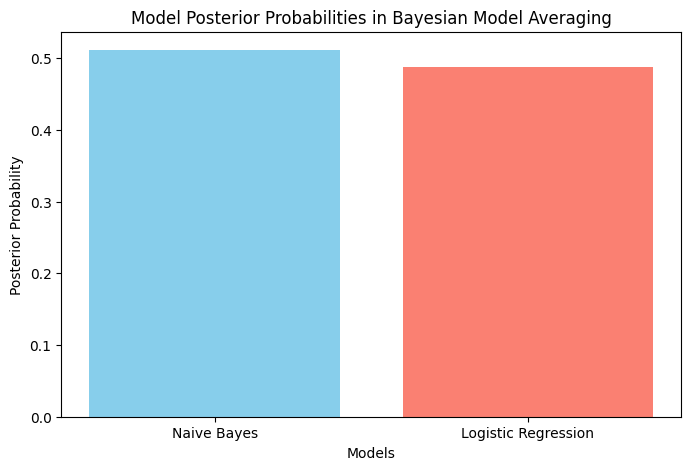

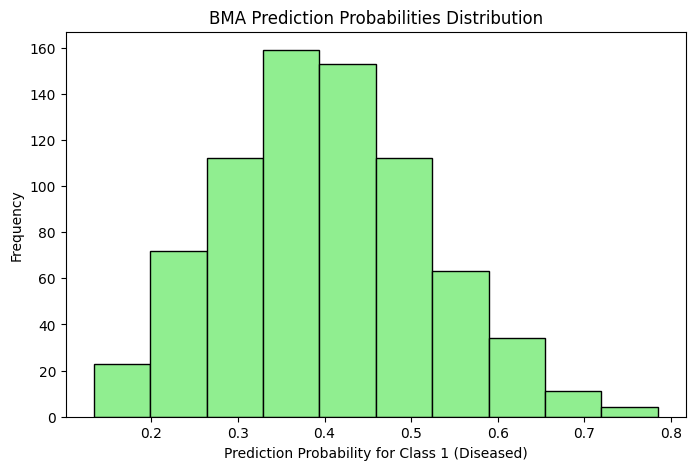

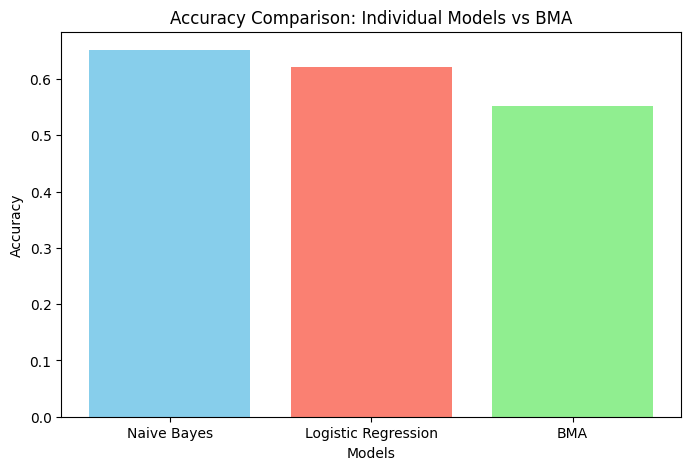

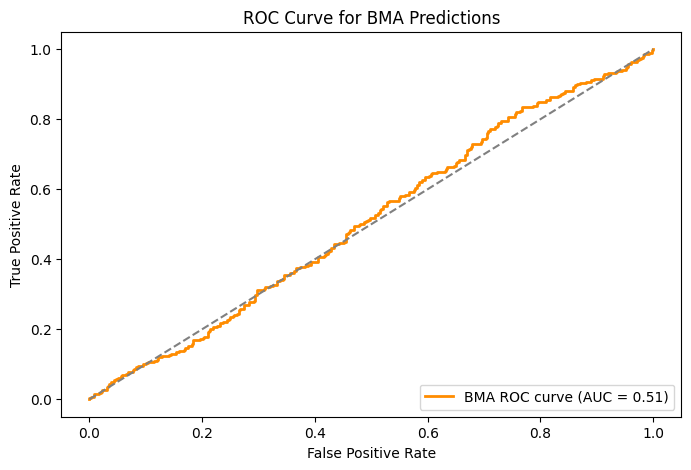

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# 1. Plot Model Posterior Probabilities
def plot_model_posteriors(model_names, posteriors):
    plt.figure(figsize=(8, 5))
    plt.bar(model_names, posteriors, color=['skyblue', 'salmon'])
    plt.xlabel("Models")
    plt.ylabel("Posterior Probability")
    plt.title("Model Posterior Probabilities in Bayesian Model Averaging")
    plt.show()

# Define model names and call the function
model_names = [model[0] for model in models]
plot_model_posteriors(model_names, posteriors)

# 2. Plot BMA Prediction Probabilities for the Test Set
def plot_prediction_histogram(y_pred_bma_prob):
    plt.figure(figsize=(8, 5))
    plt.hist(y_pred_bma_prob, bins=10, color='lightgreen', edgecolor='black')
    plt.xlabel("Prediction Probability for Class 1 (Diseased)")
    plt.ylabel("Frequency")
    plt.title("BMA Prediction Probabilities Distribution")
    plt.show()

plot_prediction_histogram(y_pred_bma_prob)

# 3. Plot BMA vs Individual Model Accuracy
def plot_model_accuracies(model_accuracies, bma_accuracy):
    model_names = list(model_accuracies.keys()) + ["BMA"]
    accuracies = list(model_accuracies.values()) + [bma_accuracy]

    plt.figure(figsize=(8, 5))
    plt.bar(model_names, accuracies, color=['skyblue', 'salmon', 'lightgreen'])
    plt.xlabel("Models")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Comparison: Individual Models vs BMA")
    plt.show()

plot_model_accuracies(model_accuracies, bma_accuracy)

# 4. ROC Curve for BMA Predictions
def plot_roc_curve(y_test, y_pred_bma_prob):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_bma_prob)
    auc_score = roc_auc_score(y_test, y_pred_bma_prob)

    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'BMA ROC curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for BMA Predictions")
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(y_test, y_pred_bma_prob)
